In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
#print(os.environ["PYTORCH_CUDA_ALLOC_CONF"])
base_dir = '../'

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print(mp.cpu_count(),' CPUs available')

from train import model, get_data, loss

Device: cuda
16  CPUs available
Device: cuda
16  CPUs available


In [2]:
%%time
torch.cuda.empty_cache()

# load data
(tensor_list, metrics),y = get_data()
print('Loaded Data, %i essays'%len(tensor_list))

Loaded Data, 29518 essays
CPU times: user 15.8 s, sys: 6.35 s, total: 22.2 s
Wall time: 1min 43s


In [50]:
#seed = 8675309 # for train test splitting
seed = 6287 # for train test splitting
num_epochs = 15
batch_size = 10

# do train test split
N_essays = len(tensor_list)
inds = np.arange(N_essays)
train_inds, test_inds = train_test_split(inds, test_size=0.2, random_state=seed, shuffle=True)
(num_epochs,seed,batch_size)

(15, 6287, 10)

In [51]:
with open(base_dir+'training/train_loss_%iepochs_seed%s_batch%i.npy'%(num_epochs,seed,batch_size), 'rb') as f:
    batch_loss = np.load(f)

In [52]:
batch_loss

array([[0.46818816, 0.46091691],
       [0.45571135, 0.40558007],
       [0.45146074, 0.37814853],
       [0.4479693 , 0.37623635],
       [0.44732728, 0.41017884],
       [0.44694487, 0.43565732],
       [0.62911024, 0.7904554 ],
       [0.78360453, 0.79050815],
       [0.65499827, 0.37120599],
       [0.38580048, 0.46685511],
       [0.38385566, 0.38168266],
       [0.35151857, 0.35784805],
       [0.34517932, 0.34534582],
       [0.34540364, 0.3646417 ],
       [0.34785323, 0.37514764]])

Text(0.5, 0, 'Epoch')

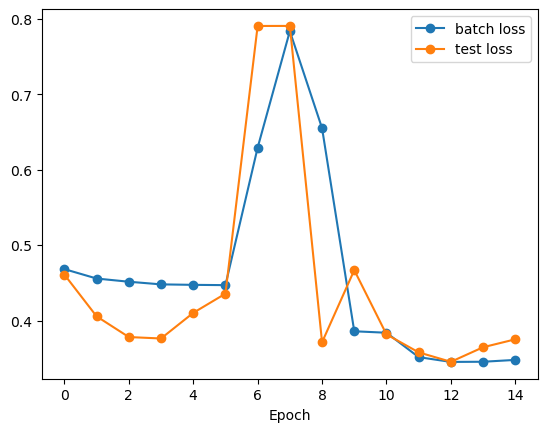

In [53]:
plt.plot(np.arange(num_epochs), batch_loss[:,0], 'o-', label='batch loss')
plt.plot(np.arange(num_epochs), batch_loss[:,1], 'o-', label='test loss')
plt.legend()

plt.xlabel('Epoch')

In [54]:
with open(base_dir+'training/train_loss_all_%iepochs_seed%s_batch%i.npy'%(15, 6287, 10), 'rb') as f:
    batch_loss_all = np.load(f)
batch_loss_all = batch_loss_all[:,0,:]

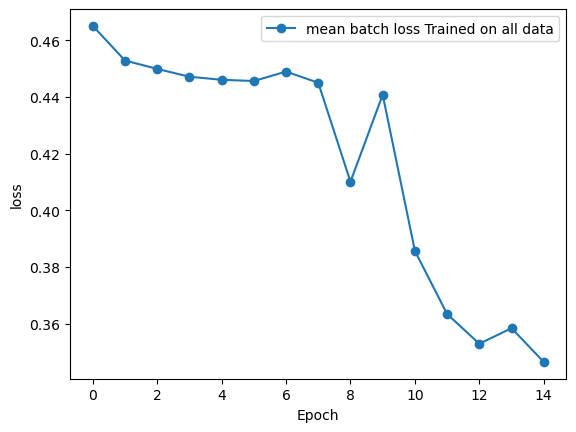

In [55]:
plt.plot(np.arange(num_epochs), np.mean(batch_loss_all, axis=1), 'o-', label='mean batch loss Trained on all data')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

---
## Calculate Test set predictions at each epoch

In [44]:
%%time
epoch_loss = []

epoch_preds = []

for epoch in range(num_epochs):
    print(epoch)
    # load it
    model_weights_path = base_dir+'training/model_weights_epoch%i_seed%s_batch%i.pt'%(epoch,seed,batch_size)
    model.load_state_dict(torch.load(model_weights_path))
    model.eval()
    
    y_probs = []
    for ind in test_inds:
        x_text = tensor_list[ind].reshape(-1,1,300)
        x_met = metrics[ind].reshape(1,5)
        y_prob = model(x_text,x_met)
        y_probs.append(y_prob)
    L = loss(torch.cat(y_probs), y[test_inds])
    preds = torch.argmax(torch.cat(y_probs), axis=1).to('cpu').numpy()
    epoch_loss.append(L.item())
    epoch_preds.append(preds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
CPU times: user 2min 7s, sys: 2min 2s, total: 4min 10s
Wall time: 4min 10s


### Check accuracy and the epoch with the smallest test loss
Precision = True Positive / (True Positive + False Positive)

Accuracy = (True Positive + True Negative) / (True Positive + False Positive + True Negative + False Negative)

In [62]:
model_weights_path 

'../training/model_weights_epoch14_seed6287_batch10.pt'

accuracy =  0.9895600298284862
precision =  0.9678184281842819
[[0.44952575 0.02743902]
 [0.00474255 0.51829268]]


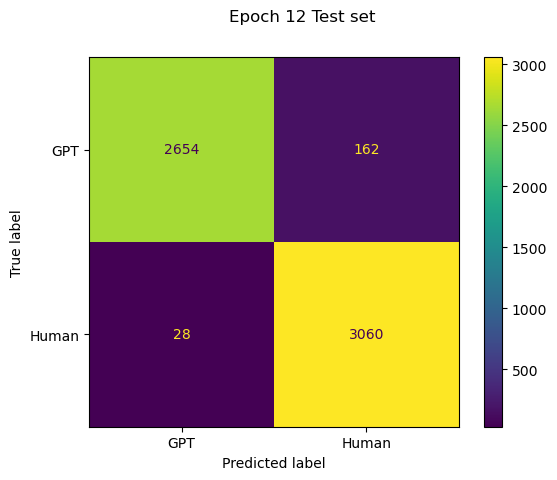

In [65]:
good_epoch = 12
y_test = torch.argmax(y[test_inds], axis=1).to('cpu').numpy()
predictions = epoch_preds[good_epoch]
conf_mat = confusion_matrix(y_test, predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['GPT', 'Human'])
disp.plot()
plt.suptitle('Epoch %i Test set'%good_epoch)


accuracy = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0])
precision = (conf_mat[0,0] + conf_mat[1,1])/np.sum(conf_mat)

print('accuracy = ', accuracy)
print('precision = ', precision)
print(conf_mat/np.sum(conf_mat))